<a href="https://colab.research.google.com/github/Mayokun-Olawale/Income-Classification-Model/blob/main/Income_Classisfication_Mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [52]:
fileName = "censusData.csv"

In [53]:
adultDataSet_filename = os.path.join(os.getcwd(),fileName)

In [54]:
df = pd.read_csv(adultDataSet_filename)
print(df.columns)
print(df.head())
print(df.shape)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex_selfID',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_binary'],
      dtype='object')
    age         workclass  fnlwgt  education  education-num  \
0  39.0         State-gov   77516  Bachelors             13   
1  50.0  Self-emp-not-inc   83311  Bachelors             13   
2  38.0           Private  215646    HS-grad              9   
3  53.0           Private  234721       11th              7   
4  28.0           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race  sex_selfID  \
0       Never-married       Adm-clerical  Not-in-family  White  Non-Female   
1  Married-civ-spouse    Exec-managerial        Husband  White  Non-Female   
2            Divorced  Handlers-cleaners  Not-in-family  White  Non-Female   
3  Married-civ-spouse  Handlers-cleaners   

In [55]:
df[df.columns].dtypes

,0
age,float64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex_selfID,object


In [56]:
#Dropping columns that could lead to bias or is too much computation power to one-hot encode
df = df.drop(columns = ['race', 'marital-status', 'relationship', 'occupation'])

In [57]:
df.head()

,age,workclass,fnlwgt,education,education-num,sex_selfID,capital-gain,capital-loss,hours-per-week,native-country,income_binary
0,39.0,State-gov,77516,Bachelors,13,Non-Female,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Non-Female,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,HS-grad,9,Non-Female,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,11th,7,Non-Female,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,Bachelors,13,Female,0,0,40.0,Cuba,<=50K


In [58]:
list(df['workclass'].unique())

['State-gov',
 'Self-emp-not-inc',
 'Private',
 'Federal-gov',
 'Local-gov',
 nan,
 'Self-emp-inc',
 'Without-pay',
 'Never-worked']

In [59]:
#Merging all government job workclass into one and naming it gov
columns_gov = (df['workclass'] == 'State-gov') | (df['workclass'] == 'Local-gov')| (df['workclass'] == 'Federal-gov')
condition = columns_gov
df['workclass'] = np.where(condition, 'Gov_job', df['workclass'])
list(df['workclass'].unique())

['Gov_job',
 'Self-emp-not-inc',
 'Private',
 nan,
 'Self-emp-inc',
 'Without-pay',
 'Never-worked']

In [60]:
#Merge the 'Without-pay' and 'Never-worked' because they mean the same thing when looking at income for this particular instance.
columns_no_pay = (df['workclass'] == 'Without-pay') | (df['workclass'] == 'Never-worked')
condition = columns_no_pay
df['workclass'] = np.where(condition, 'No-current-income', df['workclass'])
list(df['workclass'].unique())

['Gov_job',
 'Self-emp-not-inc',
 'Private',
 nan,
 'Self-emp-inc',
 'No-current-income']

In [61]:
print(df['education-num'].unique())
print(df['education'].unique())

[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


In [62]:
#Dropping 'education' because the column education-num gives the apporiate weight for each education level.
df = df.drop(columns = ['education'])

In [63]:
#Changing the 'Self-emp-inc' column into true/false values. True if female and false if otherwise
df['sex_selfID'] = df['sex_selfID'].replace({'Non-Female': False, 'Female': True})
df = df.rename(columns = {'sex_selfID':'Is_Female'})

In [64]:
df.head()
df = df.rename(columns = {'native-country':'US_native_country'})
df.head()

,age,workclass,fnlwgt,education-num,Is_Female,capital-gain,capital-loss,hours-per-week,US_native_country,income_binary
0,39.0,Gov_job,77516,13,False,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,13,False,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,9,False,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,7,False,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,13,True,0,0,40.0,Cuba,<=50K


In [65]:
df['US_native_country'].unique()
df['US_native_country'] = df['US_native_country'] == 'United-States'

In [66]:
df.head()

,age,workclass,fnlwgt,education-num,Is_Female,capital-gain,capital-loss,hours-per-week,US_native_country,income_binary
0,39.0,Gov_job,77516,13,False,2174,0,40.0,True,<=50K
1,50.0,Self-emp-not-inc,83311,13,False,0,0,13.0,True,<=50K
2,38.0,Private,215646,9,False,0,0,40.0,True,<=50K
3,53.0,Private,234721,7,False,0,0,40.0,True,<=50K
4,28.0,Private,338409,13,True,0,0,40.0,False,<=50K


In [67]:
#Binary classify the label income_binary to True/False values
df = df.rename(columns = {'income_binary': 'income_>50k'})
df['income_>50k'] = df['income_>50k'] == '>50K'
df.head()
df.shape

(32561, 10)

In [68]:
#Removing all null values
df_clean = df.dropna()
#print(df.isnull())
print(df_clean.shape)
df = df_clean
print(df.isnull().values.any())

(30272, 10)
False


In [69]:
df_workclass = pd.get_dummies(df['workclass'], prefix = 'workclass_')
df_workclass.head()
df = df.join(df_workclass)
df = df.drop(columns = ['workclass'])


In [70]:
df.head()

,age,fnlwgt,education-num,Is_Female,capital-gain,capital-loss,hours-per-week,US_native_country,income_>50k,workclass__Gov_job,workclass__No-current-income,workclass__Private,workclass__Self-emp-inc,workclass__Self-emp-not-inc
0,39.0,77516,13,False,2174,0,40.0,True,False,True,False,False,False,False
1,50.0,83311,13,False,0,0,13.0,True,False,False,False,False,False,True
2,38.0,215646,9,False,0,0,40.0,True,False,False,False,True,False,False
3,53.0,234721,7,False,0,0,40.0,True,False,False,False,True,False,False
4,28.0,338409,13,True,0,0,40.0,False,False,False,False,True,False,False


In [71]:
df.shape

(30272, 14)

In [72]:
df.dtypes

,0
age,float64
fnlwgt,int64
education-num,int64
Is_Female,bool
capital-gain,int64
capital-loss,int64
hours-per-week,float64
US_native_country,bool
income_>50k,bool
workclass__Gov_job,bool


In [73]:
#I am going to convert the columns with a bool data type into integers, in order to help the model understand the data better.
bool_dataType = ['Is_Female', 'US_native_country', 'income_>50k']
df[bool_dataType] = df[bool_dataType].astype(int)
print(df.dtypes)
print(df.head())

age                             float64
fnlwgt                            int64
education-num                     int64
Is_Female                         int64
capital-gain                      int64
capital-loss                      int64
hours-per-week                  float64
US_native_country                 int64
income_>50k                       int64
workclass__Gov_job                 bool
workclass__No-current-income       bool
workclass__Private                 bool
workclass__Self-emp-inc            bool
workclass__Self-emp-not-inc        bool
dtype: object
    age  fnlwgt  education-num  Is_Female  capital-gain  capital-loss  \
0  39.0   77516             13          0          2174             0   
1  50.0   83311             13          0             0             0   
2  38.0  215646              9          0             0             0   
3  53.0  234721              7          0             0             0   
4  28.0  338409             13          1             0      

In [74]:
df.columns

Index(['age', 'fnlwgt', 'education-num', 'Is_Female', 'capital-gain',
       'capital-loss', 'hours-per-week', 'US_native_country', 'income_>50k',
       'workclass__Gov_job', 'workclass__No-current-income',
       'workclass__Private', 'workclass__Self-emp-inc',
       'workclass__Self-emp-not-inc'],
      dtype='object')

In [75]:
df['capital-gain'].unique()

array([ 2174,     0, 14084,  5178,  5013,  2407,  7688,  4064,  4386,
        7298,  1409,  3674,  1055,  2050,  2176,   594,  6849,  4101,
        8614,  3411,  2597,  4650,  9386,  2463,  3103, 10605,  2964,
        3325,  2580,  3471,  4865,  6514,  1471,  2329,  2105,  2885,
       10520,  2202,  2961,  6767,  2228,  1506, 13550,  2635,  5556,
        4787,  3781,  3137,  3818,   914,   401,  2829,  2977,  4934,
        2062,  2354,  3464,  5455,  1424,  3273,  4416, 10566,  4931,
        7430,  6497,  3908,   114,  7896,  2346,  2907,  1151,  2414,
        2290,  3418,  4508,  2538,  3456,  1848,  3887,  5721,  9562,
        6418,  1455,  2036,  3942,  1831, 11678,  2936,  2993,  7443,
        6360,  4687,  1797,  6723,  2009,  3432,  6097,  1639,  2653,
         991,  1173,  2387,  5060,  1086])

In [76]:
df['capital-loss'].unique()

array([   0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816,
       1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721,
       2051, 2377, 1669, 2352, 1672,  653, 2392, 1504, 1590, 1651, 1628,
       1848, 2001, 1740, 2002, 1579, 2258, 1602, 2547, 2205, 1726, 2444,
       1138, 2238,  625,  213, 1539,  880, 1668, 1092, 1594, 3004, 2231,
       1844,  810, 2824, 2559, 2057, 1974,  974, 2174, 2149, 1735, 1258,
       2129, 2603, 2282,  323, 2246, 1617, 1648, 1825, 3770, 1755, 3683,
       4356, 2267, 2080, 2457,  419,  155, 3900, 2201, 1944, 2467, 2754,
       2472, 1411])

In [77]:
#Scaling all non-binary/ordinal numeric columns
numerical_features = ['age', 'fnlwgt','capital-gain',
       'capital-loss', 'hours-per-week']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.columns
df.head()

,age,fnlwgt,education-num,Is_Female,capital-gain,capital-loss,hours-per-week,US_native_country,income_>50k,workclass__Gov_job,workclass__No-current-income,workclass__Private,workclass__Self-emp-inc,workclass__Self-emp-not-inc
0,0.042334,-1.065605,13,0,0.629123,-0.219521,-0.079955,1,0,True,False,False,False,False
1,0.880589,-1.010707,13,0,-0.257028,-0.219521,-2.329849,1,0,False,False,False,False,True
2,-0.033871,0.242956,9,0,-0.257028,-0.219521,-0.079955,1,0,False,False,True,False,False
3,1.109204,0.423661,7,0,-0.257028,-0.219521,-0.079955,1,0,False,False,True,False,False
4,-0.795921,1.405939,13,1,-0.257028,-0.219521,-0.079955,0,0,False,False,True,False,False


In [78]:
print(df.columns)

Index(['age', 'fnlwgt', 'education-num', 'Is_Female', 'capital-gain',
       'capital-loss', 'hours-per-week', 'US_native_country', 'income_>50k',
       'workclass__Gov_job', 'workclass__No-current-income',
       'workclass__Private', 'workclass__Self-emp-inc',
       'workclass__Self-emp-not-inc'],
      dtype='object')


In [79]:
#Gradient Boosting  Model

In [80]:
X = df.drop(columns = 'income_>50k')
y = df['income_>50k']

In [81]:
print(X.head())
print(X.shape)
print(y.head())
print(y.shape)

        age    fnlwgt  education-num  Is_Female  capital-gain  capital-loss  \
0  0.042334 -1.065605             13          0      0.629123     -0.219521   
1  0.880589 -1.010707             13          0     -0.257028     -0.219521   
2 -0.033871  0.242956              9          0     -0.257028     -0.219521   
3  1.109204  0.423661              7          0     -0.257028     -0.219521   
4 -0.795921  1.405939             13          1     -0.257028     -0.219521   

   hours-per-week  US_native_country  workclass__Gov_job  \
0       -0.079955                  1                True   
1       -2.329849                  1               False   
2       -0.079955                  1               False   
3       -0.079955                  1               False   
4       -0.079955                  0               False   

   workclass__No-current-income  workclass__Private  workclass__Self-emp-inc  \
0                         False               False                    False   
1   

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1234)

In [83]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (20282, 13)
y_train shape: (20282,)


In [84]:
GBC_model = GradientBoostingClassifier()

In [85]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [ 0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [ 10, 20]
}

In [86]:
grid_search = GridSearchCV(estimator=GBC_model, param_grid=param_grid,
                           scoring=['accuracy', 'neg_log_loss'],  # Metrics for scoring
                           refit='accuracy',  # Refit the model using the best accuracy score
                           cv=2,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all processors
                           verbose=1,
                           )

In [87]:
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'], verbose=1)

In [88]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [89]:
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}


In [90]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, best_model.predict_proba(X_test))

print(f"Best Model Accuracy score: {accuracy}")
print(f"Best Model Log Loss: {loss}")

Best Model Accuracy score: 0.8475475475475476
Best Model Log Loss: 0.34449045984308063


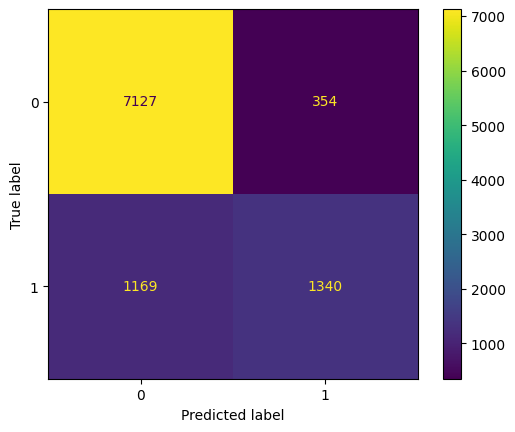

In [93]:
#Visualizing the performance of the model using a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [94]:
# ROC Curve
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

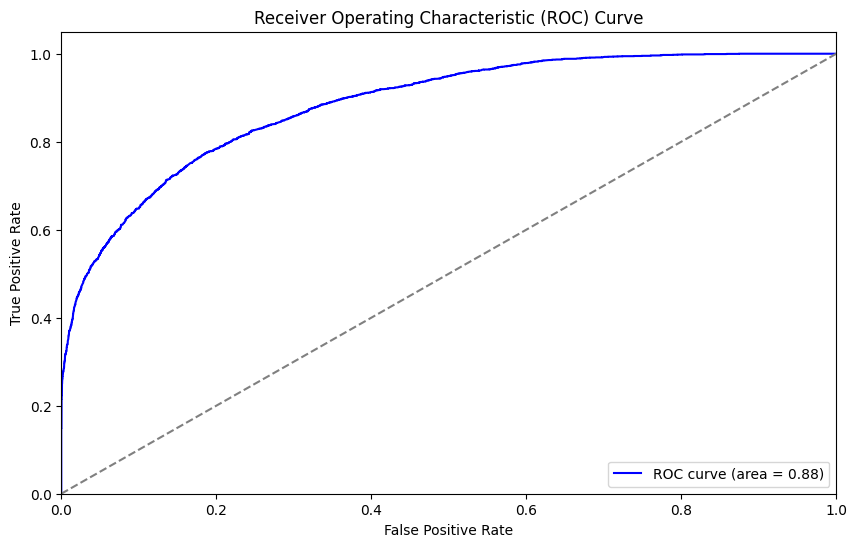

In [95]:
# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

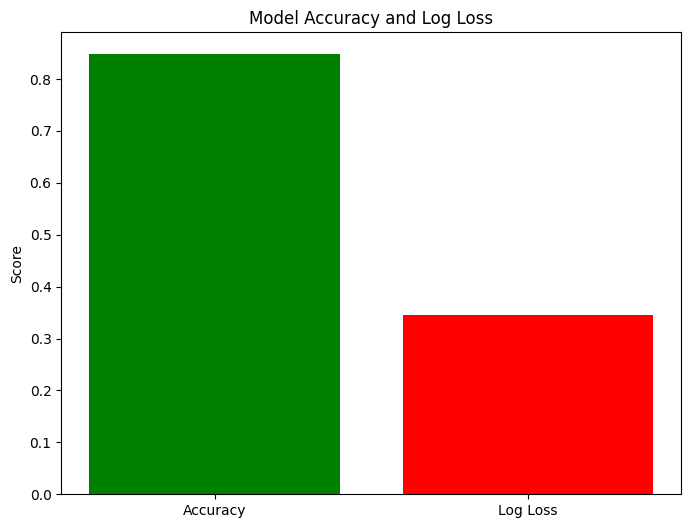

In [96]:
# Accuracy and Log Loss Bar Plot
metrics = ['Accuracy', 'Log Loss']
values = [accuracy, loss]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['green', 'red'])
plt.title("Model Accuracy and Log Loss")
plt.ylabel("Score")
plt.show()